In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
# matplotlib.use("TkAgg")
%matplotlib tk
import matplotlib.pyplot as plt

## 2D dataset

In [3]:
num_points = 100
X1 = np.linspace(-2.5, 1.9, num_points)
# X1 = np.linspace(-2.5, 2.5, num_points)
# X2 = np.linspace(-2.5, 3, num_points)
X2 = np.linspace(-2.2, 2.1, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1
Y = Y/2

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))


In [4]:
# %matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
from convex_lib import ConvexNN

In [6]:
EPOCHS = 1000
# actf = nn.LeakyReLU
actf = nn.ELU
learning_rate = 0.005
criterion = nn.MSELoss()

# Convex NN

In [7]:
cvxNet = ConvexNN([2, 15, 15, 1], actf)
optimizer = torch.optim.Adam(cvxNet.parameters(), lr=learning_rate)

In [8]:
%matplotlib tk
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

for epoch in range(EPOCHS):

    yout = -cvxNet(xx)    
    loss = criterion(yout, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch%100 == 0 or epoch==EPOCHS-1:
        print(f'Epoch: {epoch}, Loss:{float(loss)}')
        ax.clear()
        ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        ax2.clear()
        ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()

Epoch: 0, Loss:0.16412848234176636
Epoch: 100, Loss:0.03107333742082119
Epoch: 200, Loss:0.02948790043592453
Epoch: 300, Loss:0.01967701129615307
Epoch: 400, Loss:0.018112506717443466
Epoch: 500, Loss:0.018044279888272285
Epoch: 600, Loss:0.018035249784588814
Epoch: 700, Loss:0.018031639978289604
Epoch: 800, Loss:0.01802847534418106
Epoch: 900, Loss:0.01802309788763523
Epoch: 999, Loss:0.018003128468990326


/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


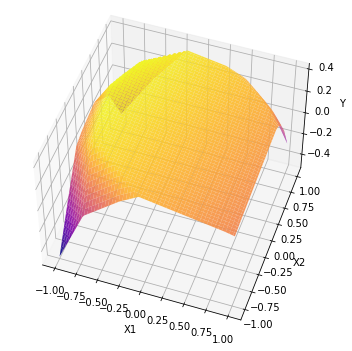

In [9]:
%matplotlib inline

y_ = yout.data.cpu().numpy().reshape(Y.shape)

fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.view_init(49, -71)
ax.plot_surface(X1, X2, y_, cmap='plasma', alpha=0.9)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
# plt.pause(0.1)
plt.show()

## Plotting Contour Plot

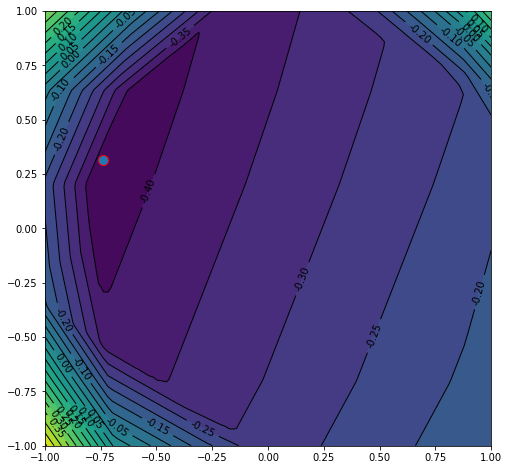

In [10]:
# LVLs = np.linspace(sim.min(), sim.max(), 20)
LVLs = 20

y_ = cvxNet(xx).data.cpu().numpy().reshape(Y.shape)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
minima = xx[y_.argmin()]
plt.scatter(*minima.tolist(), s=100, edgecolors="red")

In [11]:
min_val = y_.min()
min_val

-0.42983565

In [12]:
minima = xx[None, y_.argmin()]
minima

tensor([[-0.7374,  0.3131]])

In [13]:
# minima[0, 0] = minima[0, 0] + 0.25
# minima[0, 1] = minima[0, 1] - 0.1

## Finding Mimima by using gradient descent

In [14]:
xmin = torch.randn_like(minima)
xmin = torch.autograd.Variable(xmin, requires_grad=True)
xmin

tensor([[-0.8129,  0.1776]], requires_grad=True)

In [15]:
optim = torch.optim.Adam([xmin], lr=0.001)
STEPS = 4000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=STEPS)

### Training Loop

In [16]:
for step in range(STEPS):
    optimizer.zero_grad() 

    ymin = cvxNet(xmin)
    xgrad = torch.autograd.grad(outputs=ymin, inputs=xmin, grad_outputs=torch.ones_like(ymin), 
                            only_inputs=True, retain_graph=True, create_graph=True)[0]
    xmin.grad = xgrad
    
    optim.step()
    scheduler.step()
    
    if step%100 == 0:
        print(f"STEPS: {step}, xmin: {xmin.data}, min_value: {ymin.data}")

STEPS: 0, xmin: tensor([[-0.8119,  0.1786]]), min_value: tensor([[-0.4025]])
STEPS: 100, xmin: tensor([[-0.7738,  0.2161]]), min_value: tensor([[-0.4283]])
STEPS: 200, xmin: tensor([[-0.7606,  0.2277]]), min_value: tensor([[-0.4290]])
STEPS: 300, xmin: tensor([[-0.7522,  0.2628]]), min_value: tensor([[-0.4296]])
STEPS: 400, xmin: tensor([[-0.7436,  0.3044]]), min_value: tensor([[-0.4302]])
STEPS: 500, xmin: tensor([[-0.7420,  0.3103]]), min_value: tensor([[-0.4303]])
STEPS: 600, xmin: tensor([[-0.7417,  0.3103]]), min_value: tensor([[-0.4302]])
STEPS: 700, xmin: tensor([[-0.7419,  0.3108]]), min_value: tensor([[-0.4303]])
STEPS: 800, xmin: tensor([[-0.7417,  0.3108]]), min_value: tensor([[-0.4302]])
STEPS: 900, xmin: tensor([[-0.7422,  0.3117]]), min_value: tensor([[-0.4303]])
STEPS: 1000, xmin: tensor([[-0.7412,  0.3109]]), min_value: tensor([[-0.4302]])
STEPS: 1100, xmin: tensor([[-0.7423,  0.3118]]), min_value: tensor([[-0.4303]])
STEPS: 1200, xmin: tensor([[-0.7417,  0.3112]]), min

In [17]:
xgrad

tensor([[-0.0520, -0.0039]], grad_fn=<AddBackward0>)

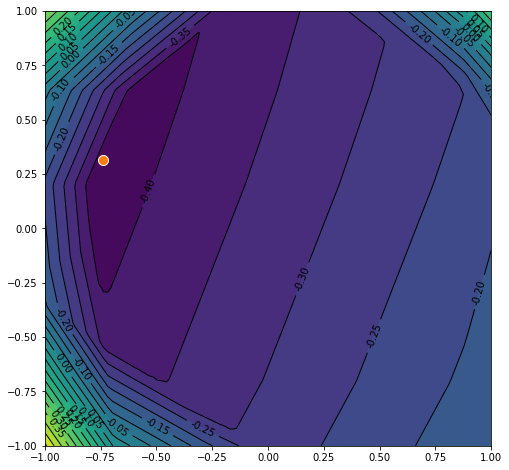

In [18]:
# LVLs = np.linspace(sim.min(), sim.max(), 20)
LVLs = 20

y_ = cvxNet(xx).data.cpu().numpy().reshape(Y.shape)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
minima = xx[y_.argmin()]
plt.scatter(*minima.tolist(), s=100, edgecolors="red")
plt.scatter(*xmin.data[0].tolist(), s=100, edgecolors="white")

In [19]:
minima = xmin.data
min_val = ymin.data[0].item()
minima, min_val

(tensor([[-0.7415,  0.3137]]), -0.4303455352783203)

## Using Learned function for Distance

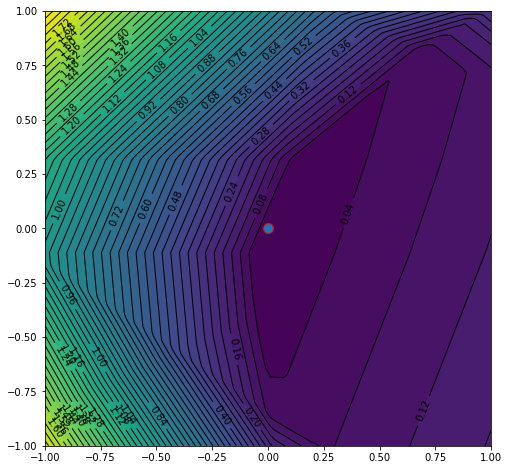

In [20]:
xx_ = xx + minima
y_ = cvxNet(xx_).data.cpu().numpy().reshape(Y.shape)- min_val
# y_ = y_**0.5

LVLs = 50
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
plt.scatter(0, 0, s=100, edgecolors="red")

## Contour as Distance

In [21]:
def get_contour_distance(level=1.0):
    xx_ =  xx
    x_norm = torch.norm(xx_, dim=1, keepdim=True)
    xx_= xx_/x_norm*level
    y_ = cvxNet(xx_+ minima) - min_val
    y_ = y_*x_norm/level
#     y_ = 1/y_*x_norm/level ### This also works but takes inverse distance

    return y_

<a list of 61 text.Text objects>

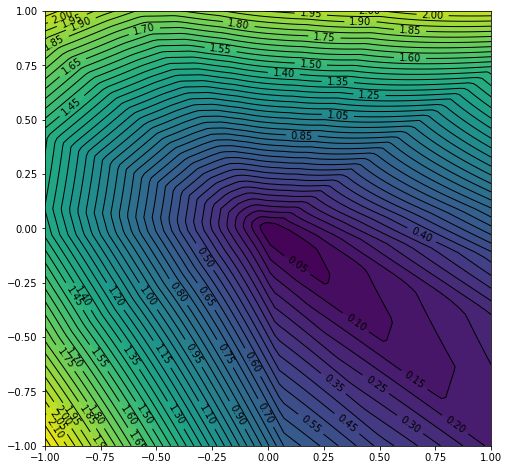

In [22]:
y_ = get_contour_distance(3.5).data.cpu().numpy().reshape(Y.shape)#**0.5

LVLs = 50
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
# plt.scatter(0, 0, s=100, edgecolors="red")

In [23]:
y_.min()

0.0019133433

In [24]:
'''
Observation: -> for some noisy minima found...
1) The function seems like a convex contour of different shape. (not always convex - sometimes 1-invex)
2) The magnitude of slope of the function in different direction seems different.
        (Having same slope in all direction would mean a good distance like Lp-norms)
'''

'\nObservation: -> for some noisy minima found...\n1) The function seems like a convex contour of different shape. (not always convex - sometimes 1-invex)\n2) The magnitude of slope of the function in different direction seems different.\n        (Having same slope in all direction would mean a good distance like Lp-norms)\n'

In [25]:
def get_contour_distance_lp(level=1.0, p=1):
    xx_ =  xx
    x_norm = torch.norm(xx_, dim=1, keepdim=True)
    xx_= xx_/x_norm*level
    y_ = torch.norm(xx_, p=p, dim=1, keepdim=True)
    y_ = y_*x_norm#/level
    return y_

<a list of 112 text.Text objects>

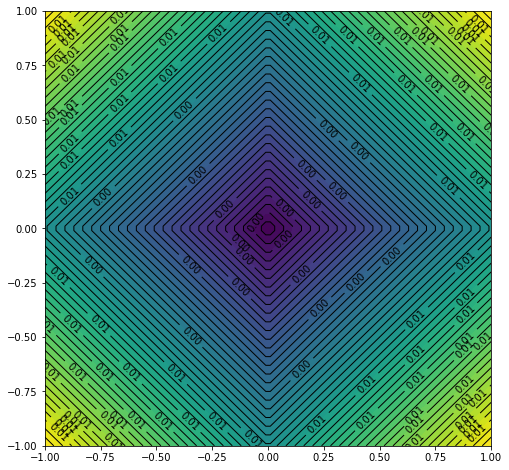

In [26]:
y_ = get_contour_distance_lp(0.005, p=1).data.cpu().numpy().reshape(Y.shape)

LVLs = 50
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
# plt.scatter(0, 0, s=100, edgecolors="red")

In [27]:
def get_contour_distance_v2(level=1.0):
    xx_ =  xx
    x_norm = torch.norm(xx_, dim=1, keepdim=True)
#     xx_= xx_/x_norm*level
    y_ = cvxNet(xx_+ minima) - min_val
#     y_ = y_*x_norm/level

    xx_2= xx*y_/x_norm
#     y_2 = cvxNet(xx_2+ minima) - min_val

    y_2 = torch.norm(xx_2, p=2, dim=1, keepdim=True)
    
    
    return y_2

In [28]:
def get_contour_distance_v3(level=1.0):
    xx_ =  xx
    x_norm = torch.norm(xx_, dim=1, keepdim=True)
    xx_= xx_/x_norm*level
    y_ = cvxNet(xx+ minima) - min_val
    y_ = y_*x_norm/level
    return y_

<a list of 59 text.Text objects>

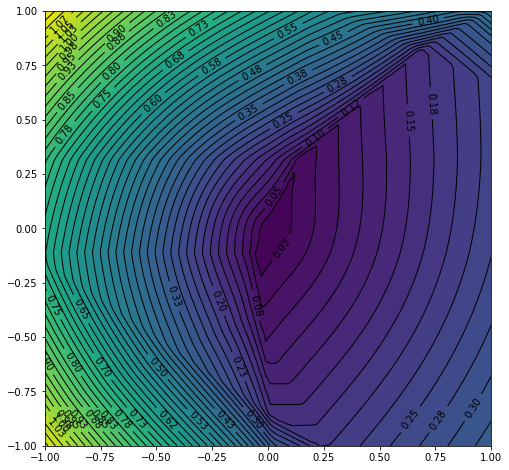

In [29]:
y_ = get_contour_distance_v3(2).data.cpu().numpy().reshape(Y.shape)**0.5

LVLs = 50
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
# plt.scatter(0, 0, s=100, edgecolors="red")

In [30]:
xx[y_.argmin()]

tensor([0.0101, 0.0101])

### Extracting the Exact Contour 

In [31]:
"""
PROBLEM:
A. The contours generated by using convex function as a distance can produce non-convex contours.
B. Extracting the exact contours given a function is difficult (not made in such a way)


SOLUTION
Getting distance to a specific contour (a) in a given direction from the center. 
1. Make mimima at given (a) and optimize xx only in the magnitude. The final xx is the contour.
    a) initialize xx to unit-norm(or a) so that slight misplace in minima does not alter contour to (a)
2. distance = ||initial xx||  /  ||final xx||

BETTER -> get the exact 
"""

'\nPROBLEM:\nA. The contours generated by using convex function as a distance can produce non-convex contours.\nB. Extracting the exact contours given a function is difficult (not made in such a way)\n\n\nSOLUTION\nGetting distance to a specific contour (a) in a given direction from the center. \n1. Make mimima at given (a) and optimize xx only in the magnitude. The final xx is the contour.\n    a) initialize xx to unit-norm(or a) so that slight misplace in minima does not alter contour to (a)\n2. distance = ||initial xx||  /  ||final xx||\n\nBETTER -> get the exact \n'

In [38]:
xx.shape

torch.Size([10000, 2])

In [39]:
level = 0.05
xx_norm = torch.norm(xx, dim=1, keepdim=True)
xx_ = xx/xx_norm * level

In [40]:
xx_lnorm = torch.ones_like(xx_norm)*0.5
xx_lnorm = torch.autograd.Variable(xx_lnorm, requires_grad=True)
xx_lnorm

tensor([[0.5000],
        [0.5000],
        [0.5000],
        ...,
        [0.5000],
        [0.5000],
        [0.5000]], requires_grad=True)

In [41]:
optimizer = torch.optim.Adam([xx_lnorm], lr=0.01)
STEPS = 4000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=STEPS)

### Training Loop

In [42]:
for step in range(STEPS):
    optimizer.zero_grad() 

    yy_ = torch.abs(cvxNet(xx_*xx_lnorm + minima) - min_val - level)
    xgrad = torch.autograd.grad(outputs=yy_, inputs=xx_lnorm, grad_outputs=torch.ones_like(yy_), 
                            only_inputs=True, retain_graph=True, create_graph=True)[0]
    xx_lnorm.grad = xgrad
    
    optimizer.step()
    scheduler.step()    
    
    if step%100 == 0:
        print(f"STEPS: {step}, norm_min: {xx_lnorm.data.min()}, norm_max: {xx_lnorm.data.max()}, min_value: {ymin.data.min()}")

STEPS: 0, norm_min: 0.5099998116493225, norm_max: 0.5099999904632568, min_value: -0.4303455352783203
STEPS: 100, norm_min: 0.8997699618339539, norm_max: 1.509477972984314, min_value: -0.4303455352783203
STEPS: 200, norm_min: 0.8997887372970581, norm_max: 2.579240322113037, min_value: -0.4303455352783203
STEPS: 300, norm_min: 0.8988105058670044, norm_max: 4.65017032623291, min_value: -0.4303455352783203
STEPS: 400, norm_min: 0.8982382416725159, norm_max: 6.218432426452637, min_value: -0.4303455352783203
STEPS: 500, norm_min: 0.8984479904174805, norm_max: 7.671513557434082, min_value: -0.4303455352783203
STEPS: 600, norm_min: 0.8983156085014343, norm_max: 8.828527450561523, min_value: -0.4303455352783203
STEPS: 700, norm_min: 0.8984799385070801, norm_max: 9.87269401550293, min_value: -0.4303455352783203
STEPS: 800, norm_min: 0.8985384106636047, norm_max: 10.802700996398926, min_value: -0.4303455352783203
STEPS: 900, norm_min: 0.8985986709594727, norm_max: 11.612072944641113, min_value: -

<a list of 49 text.Text objects>

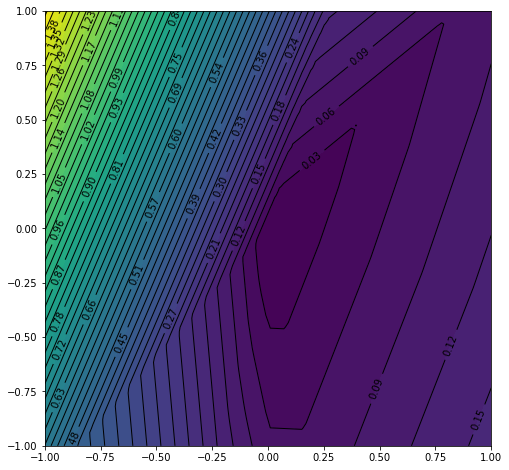

In [43]:
y_ = (xx_norm/xx_lnorm.data).cpu().reshape(X1.shape)

LVLs = 50
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

In [44]:
y_.shape

torch.Size([100, 100])

## Convex Function for refrence

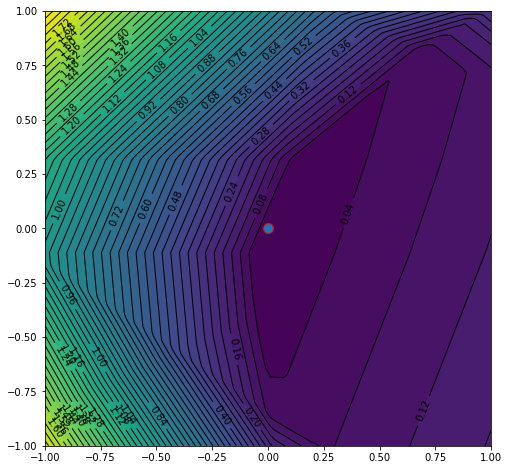

In [45]:
xx_ = xx + minima
y_ = cvxNet(xx_).data.cpu().numpy().reshape(Y.shape)- min_val
# y_ = y_**0.5

LVLs = 50
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
plt.scatter(0, 0, s=100, edgecolors="red")